In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
import math
%matplotlib inline
def process_unis():
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
    unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
    unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
        
    return unis

def process_completions(year):
    completions = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
    return completions
# hard coded it because of assignment errors

In [4]:
def startup():
    all_unis = {}
    all_completions = {}
    for year in range(2008, 2022):
        all_unis[year] = process_unis()
        all_completions[year] = process_completions(year)
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']
    return all_unis, all_completions, cols

In [5]:
def region_processing(uni_data, completion_data, region):
    uni_boolmap = uni_data['OBEREG'] == region
    region_unis = uni_data[uni_boolmap]
    unitids = set(region_unis['UNITID'])
    completion_boolmap = completion_data['UNITID'].apply(lambda x: x in unitids)
    region_data = completion_data[completion_boolmap]
    return region_data, region_unis

In [6]:
reg_code_to_label = {0: 'US Service Schools', 1: 'New England', 2: 'Mid East', 3: 'Great Lakes', 4: 'Plains',\
     5: 'Southeast',6: 'Southwest', 7: 'Rocky Mountains',8: 'Far West', 9: 'Outlying Areas'}

In [7]:
def make_years(completions, unis, region, start, end):
    years = {}
    for year in range(start, end + 1):
        year_completions, year_unis = region_processing(unis[year], completions[year], region)
        years[year] = [year_completions, year_unis]
    return years

In [24]:
# data is the dataframe already boolmapped with the proper data
def groupTotals(years):
    allStateCsData  = []
    allStateNonCsData = []
    for year in years:
        data, unis = years[year]
        csMerge, nonCsMerge = csVsNonCs(data, unis)
        csMerge['year'] = year
        nonCsMerge['year'] = year
        allStateCsData.append(csMerge)
        allStateNonCsData.append(nonCsMerge)
    allStateCsData = pd.concat(allStateCsData)
    allStateNonCsData = pd.concat(allStateNonCsData)
    return allStateCsData, allStateNonCsData
    
        
        
def csVsNonCs(data, unis):
    csBoolmap = data['CIPCODE'].apply(lambda x : x < 12 and x >= 11)
    cs = data[csBoolmap]
    csSum = cs.groupby('UNITID').sum()
    csSum = csSum.reset_index()
    uniqueIds = set(csSum['UNITID'].unique())
    nonCs = data[data.apply(lambda x: x['UNITID'] in uniqueIds, axis = 1)]
    nonCsSum = nonCs.groupby('UNITID').sum().reset_index()
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    csMerge = pd.merge(csSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    nonCsMerge = pd.merge(nonCsSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    return csMerge, nonCsMerge

In [20]:
def make_percents(cs, nonCs):
    cs = cs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    nonCs = nonCs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    cs = cs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    nonCs = nonCs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    cs = cs.reset_index()
    nonCs = nonCs.reset_index()
    return cs, nonCs

In [10]:
def cs_nonCs_difference(cs, nonCs):
    cs = cs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    nonCs = nonCs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    difference = cs - nonCs
    difference = difference.reset_index()
    return difference

In [16]:
percent_cs, percent_nonCs = make_percents(groupCs, groupNonCs)
difference = cs_nonCs_difference(percent_cs, percent_nonCs)
difference

NameError: name 'groupCs' is not defined

In [11]:
def get_avg(data):
    data = data.groupby('UNITID').mean()
    return data

In [49]:
avg = get_avg(difference)
avg

,LONGITUD,LATITUDE,year,CTOTALW,CAIANT,CBKAAT,CHISPT,CTOTALT
UNITID,,,,,,,,
100654,-86.568502,34.783368,2020.5,-0.246475,-0.001218,-0.053430,0.036778,0.0
100663,-86.799345,33.505697,2020.5,-0.391327,-0.002273,-0.090531,-0.006682,0.0
100706,-86.640449,34.724557,2020.5,-0.246830,-0.005934,-0.033921,-0.013460,0.0
100724,-86.295677,32.364317,2020.5,-0.312118,-0.002107,-0.032655,-0.011882,0.0
100751,-87.545978,33.211875,2020.5,-0.386076,-0.003384,-0.035323,-0.031543,0.0
...,...,...,...,...,...,...,...,...
490498,-93.771686,32.480613,2020.5,-0.305263,0.098684,-0.000877,0.198684,0.0
491783,-82.463419,28.488302,2020.5,-0.138095,0.000000,-0.050000,0.055952,0.0
493725,-92.343582,34.775996,2020.5,-0.329543,0.019681,-0.113417,-0.006873,0.0


In [17]:
years = make_years(all_completions, all_unis, 5, 2020, 2021)
groupCs, groupNonCs = groupTotals(years)
groupCs

NameError: name 'all_completions' is not defined

In [29]:
def uni_plot(data, fig, axs):
    #return [demo_plot(data, demo, fig, axs, i) for i, demo in enumerate(cols[1:])] 
    for i, demo in enumerate(cols[1:]):
        plot = demo_plot(data, demo, fig, axs, i)
        # if i == 0:
        #     fig.suptitle('women')
        # elif i == 1:
        #     fig.suptitle('native american')
        # elif i == 2:
        #     fig.suptitle('black')
        # else:
        #     fig.suptitle('hispanic') 
    fig.colorbar(plot, ax = axs[i])

In [13]:
def demo_plot(data, demo, fig, axs, i):
    plot = axs[i].scatter(data['LONGITUD'], data['LATITUDE'], c = data[demo], alpha = 0.5)
    axs[i].set_xlim(-130, -60)
    axs[i].set_ylim(20, 55)
    axs[i].set_title(demo)
    return plot

In [21]:
def regional_difference_mapping(start, end):
    all_unis, all_completions, cols = startup()
    fig, axs = plt.subplots(4, 1, figsize = (10, 20))
    plots = []
    for region in reg_code_to_label.keys():
        years = make_years(all_completions, all_unis, region, start, end)
        cs_group, nonCs_group = groupTotals(years)
        cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
        difference = cs_nonCs_difference(cs_percent, nonCs_percent)
        average = get_avg(difference)
        uni_plot(average, fig, axs)
    #[plt.colorbar(plot, cax = ax) for ax in axs]


In [30]:
def regional_difference_mapping2(start, end):
    all_unis, all_completions, cols = startup()
    all_averages = pd.DataFrame()
    for region in reg_code_to_label.keys():
        years = make_years(all_completions, all_unis, region, start, end)
        cs_group, nonCs_group = groupTotals(years)
        cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
        difference = cs_nonCs_difference(cs_percent, nonCs_percent)
        average = get_avg(difference)
        all_averages = pd.concat([all_averages, average])
    return all_averages
    # uni_plot(average, fig, axs)
    #[plt.colorbar(plot, cax = ax) for ax in axs]
    # fig, axs = plt.subplots(4, 1, figsize = (10, 20))
    # plots = []
all_averages = regional_difference_mapping2(2008, 2021)


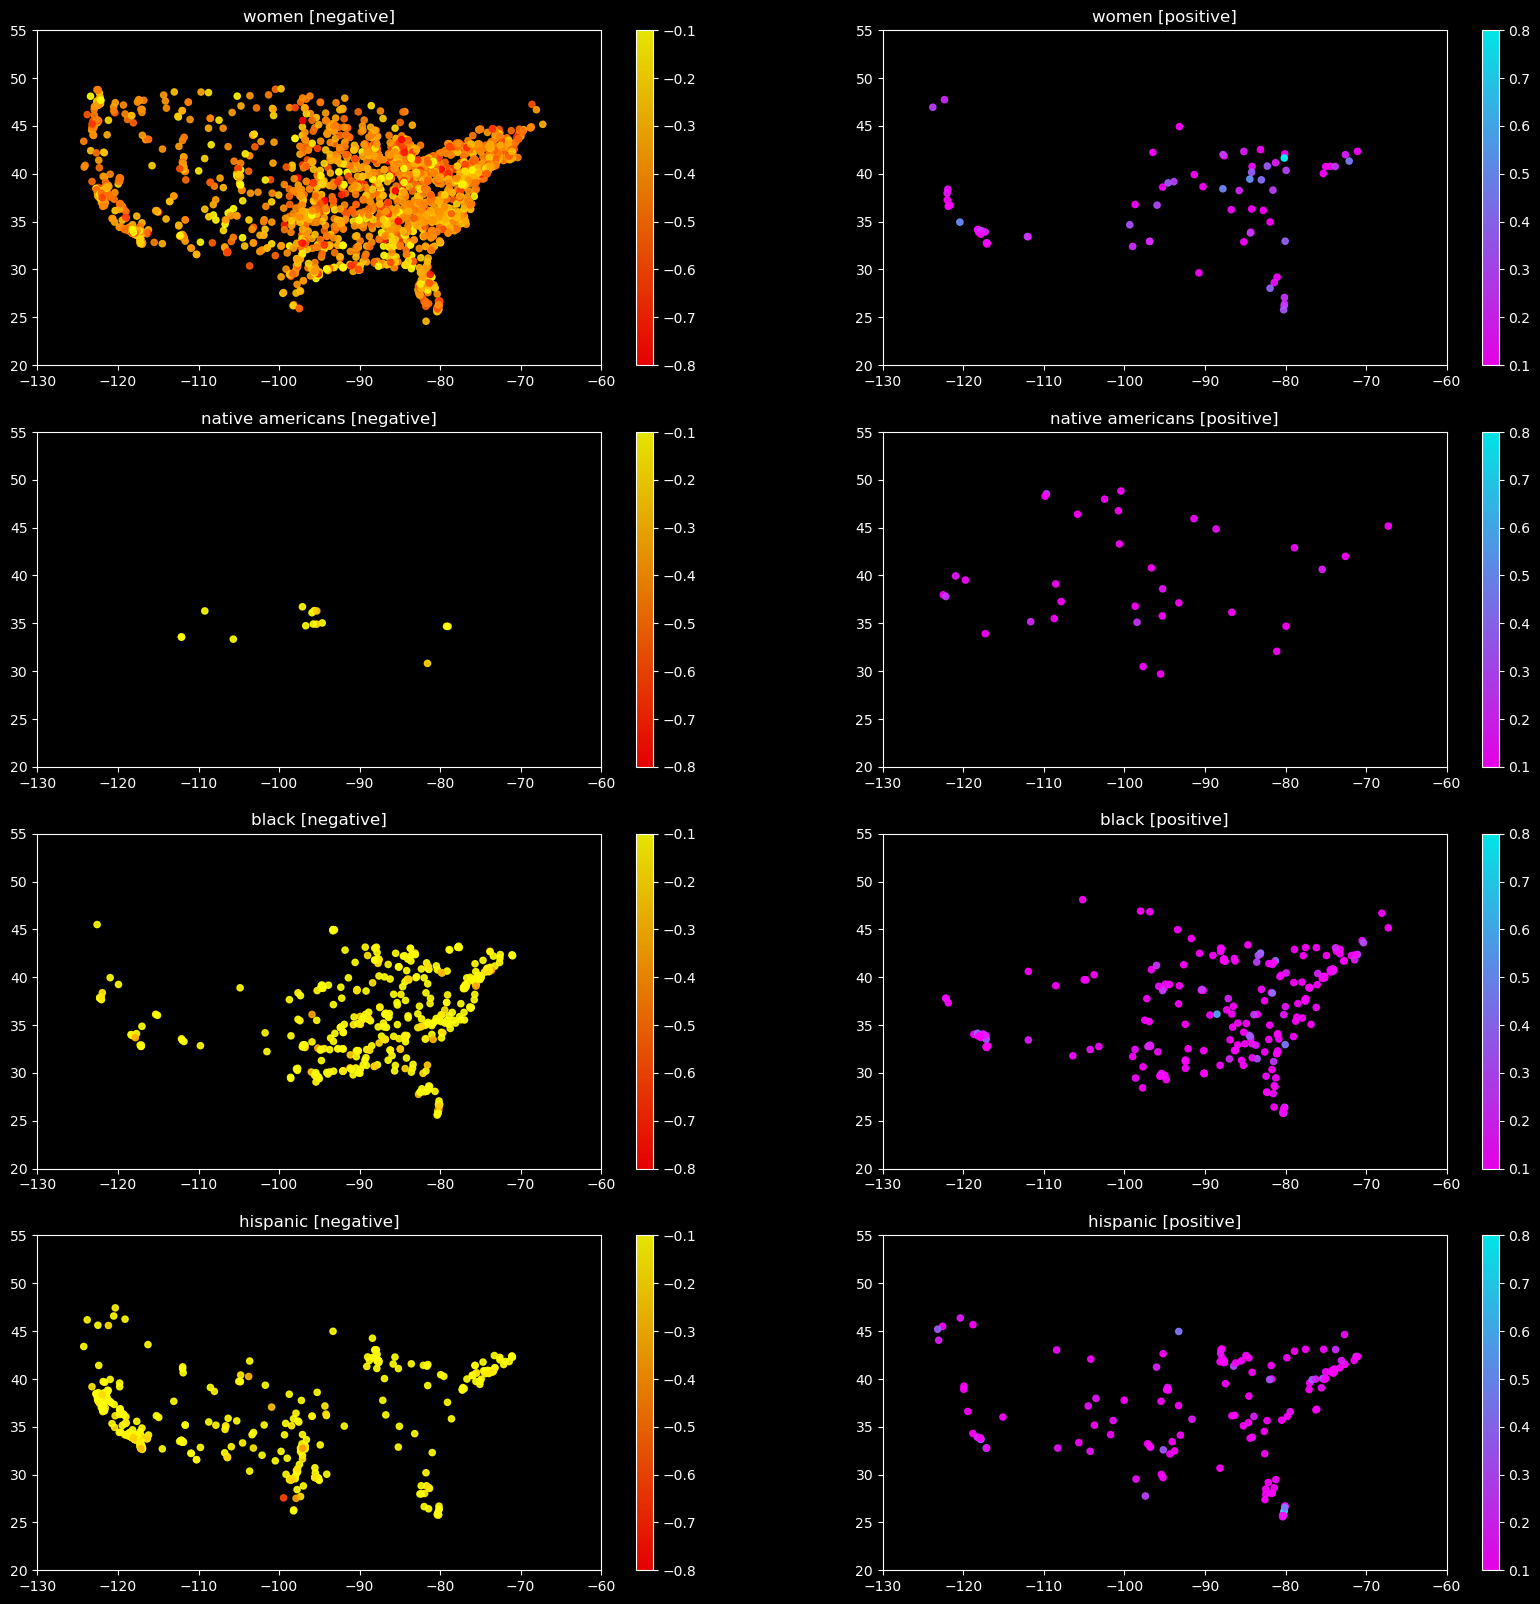

In [52]:
all_averages = all_averages.dropna()

# all_averages.head()
fig, axs = plt.subplots(4, 2, figsize = (20, 20))
demo_cols = all_averages.columns[-5:-1]
labels = ['women', 'native americans', 'black', 'hispanic']
for i, col in enumerate(demo_cols):
    neg = all_averages[all_averages[col] < -0.05]
    pos = all_averages[all_averages[col] > 0.05]
    plot = axs[i][0].scatter(neg['LONGITUD'], neg['LATITUDE'], c=neg[col], cmap='autumn', s=20, vmin=-0.8, vmax=-0.1,\
         alpha = 0.9)
    # if i == 0:
    #         fig.suptitle('women')
    # elif i == 1:
    #         fig.suptitle('native american')
    #     elif i == 2:
    #         fig.suptitle('black')
    #     else:
    #         fig.suptitle('hispanic') 
    plt.colorbar(plot, ax=axs[i][0])

    plot = axs[i][1].scatter(pos['LONGITUD'], pos['LATITUDE'], c=pos[col], cmap='cool_r', s=20, vmin=0.1, vmax=0.8, \
        alpha = 0.9)
    plt.colorbar(plot, ax=axs[i][1])
    #plt.(-1, 1)
    axs[i][0].set_xlim(-130, -60)
    axs[i][1].set_xlim(-130, -60)
    axs[i][0].set_ylim(20, 55)
    axs[i][1].set_ylim(20, 55)

    axs[i][0].set_title('%s [negative]' % labels[i])
    axs[i][1].set_title('%s [positive]' % labels[i])
plt.style.use('dark_background')


NameError: name 'cols' is not defined

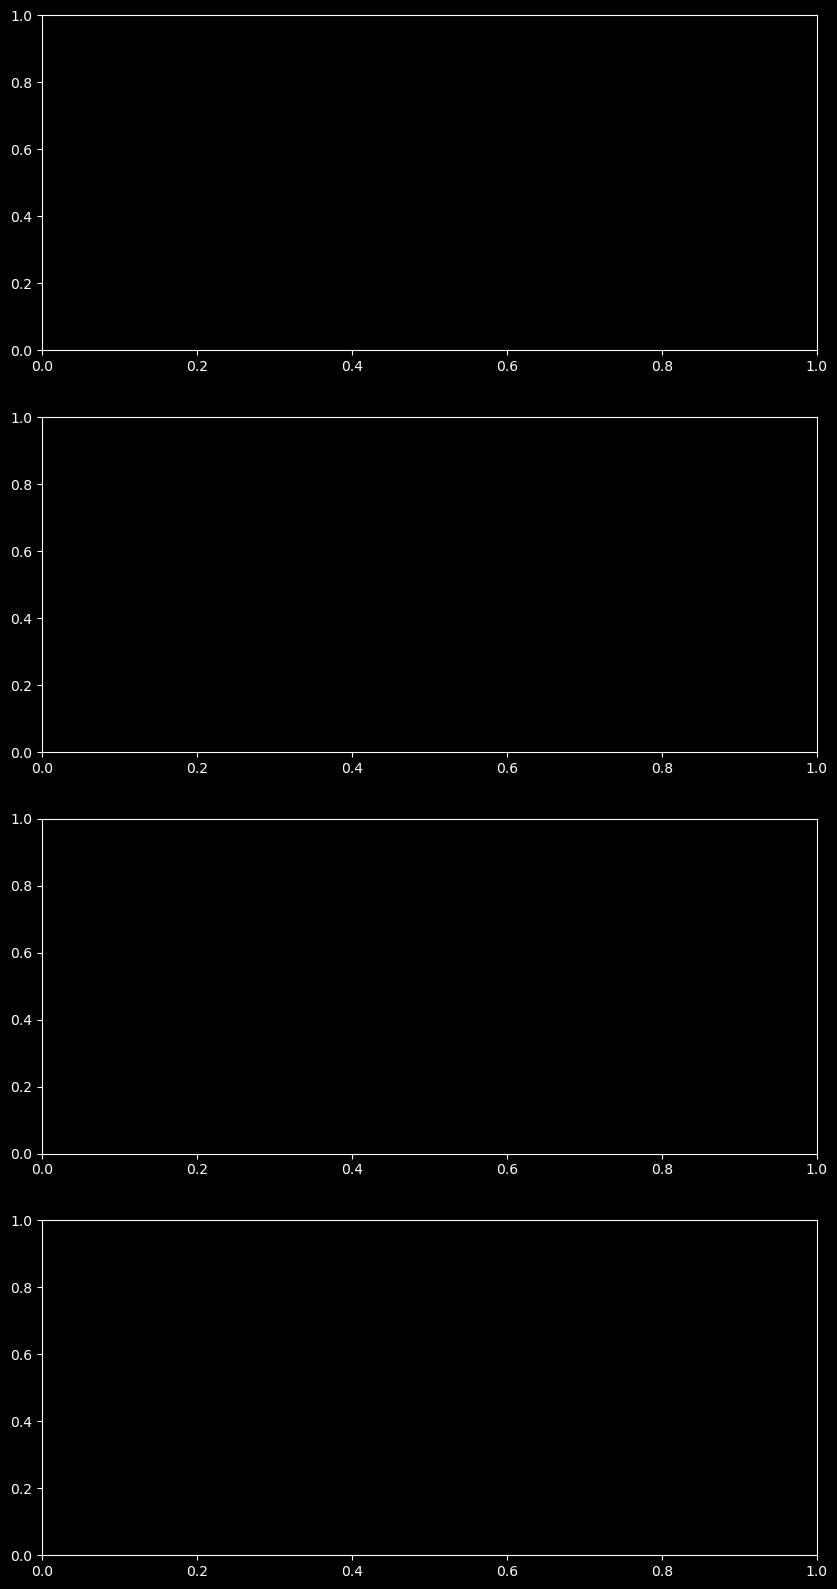

In [44]:
regional_difference_mapping(2021, 2021)

In [117]:
avg

,LONGITUD,LATITUDE,year,CTOTALW,CAIANT,CBKAAT,CHISPT,CTOTALT
UNITID,,,,,,,,
100654,-86.568502,34.783368,2020.5,-0.246475,-0.001218,-0.053430,0.036778,0.0
100663,-86.799345,33.505697,2020.5,-0.391327,-0.002273,-0.090531,-0.006682,0.0
100706,-86.640449,34.724557,2020.5,-0.246830,-0.005934,-0.033921,-0.013460,0.0
100724,-86.295677,32.364317,2020.5,-0.312118,-0.002107,-0.032655,-0.011882,0.0
100751,-87.545978,33.211875,2020.5,-0.386076,-0.003384,-0.035323,-0.031543,0.0
...,...,...,...,...,...,...,...,...
490498,-93.771686,32.480613,2020.5,-0.305263,0.098684,-0.000877,0.198684,0.0
491783,-82.463419,28.488302,2020.5,-0.138095,0.000000,-0.050000,0.055952,0.0
493725,-92.343582,34.775996,2020.5,-0.329543,0.019681,-0.113417,-0.006873,0.0
